# Reproducing figures from paper

This notebook reproduces the main figures from the paper "Efficient Probabilistic Tensor Networks". 

**Model name mappings:**
- `mps_sigma_lsf` → $\mathrm{MPS}_{\sigma+\mathrm{LSF}}$ (Non-negative MPS with logarithmic scale factors)
- `mps_sigma_sgd` → $\mathrm{MPS}_{\mathrm{BM+SGD}}$ (Non-negative MPS with standard SGD)
- `mps_bm_lsf` → $\mathrm{MPS}_{\mathrm{BM+LSF}}$ (Born machine with logarithmic scale factors))  
- `mps_bm_sgd` → $\mathrm{MPS}_{\mathrm{BM+SGD}}$ (Born machine with with standard SGD)
- `mps_bm_dmrg` → $\mathrm{MPS}_{\mathrm{BM+DMRG}}$ (Born machine wit DMRG)

## Figure 1: Profiling LSF, SGD & DMRG

#### Memory, Latency & Instability

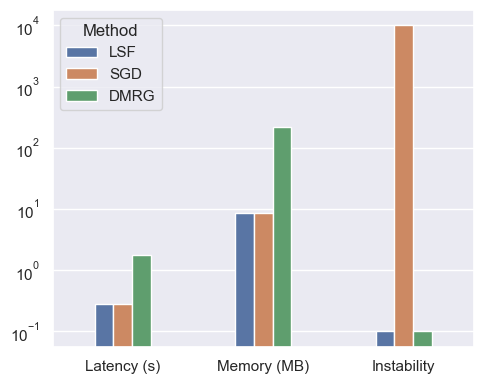

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Latency:
# >> python scripts/profile_latency.py --horizons 128 --d_output 8 --models mps_bm_dmrg mps_bm_lsf --device cpu
#     latency         name   R    H  Do  Di   B sweep_type  sweep_value                                                                                                                                                  
# 0  1.799973  mps_bm_dmrg  32  128   8   1  32          H          128
# 1  0.283370   mps_bm_lsf  32  128   8   1  32          H          128

# Memory:
# >> python scripts/profile_memory.py --d_outputs 1024 --models mps_bm_dmrg mps_bm_lsf
#          model     d      mem_mb
# 0  mps_bm_dmrg  1024  217.106445
# 1   mps_bm_lsf  1024    8.676270

# Instability:
# >> python scripts/profile_instability.py --horizons 100
#         name   horizon   iters
# 0  mps_bm_lsf      100  10000
# 1  mps_bm_sgd      100      1
sns.set_theme()

instability_fn = lambda N: 10000 - N + 0.1

# Data
df_latency_mem = pd.DataFrame({
    "Method": [r"LSF", r"SGD", r"DMRG"],
    "Latency (s)": [0.28, 0.28, 1.8], # SGD and LSF have same latency
    "Memory (MB)": [8.7, 8.7, 217],
    "Instability": [instability_fn(10000), instability_fn(1), instability_fn(10000)],
})

# Melt the dataframe for easier plotting with seaborn
df_melted = df_latency_mem.melt(id_vars="Method", var_name="Metric", value_name="Value")

plt.figure(figsize=(5, 4))  # smaller width
sns.barplot(
    data=df_melted,
    x="Metric",
    y="Value",
    hue="Method",
    width=0.4 
)
plt.yscale("log")
ax = plt.gca()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

## Figure 3: Stability analysis (Part I)

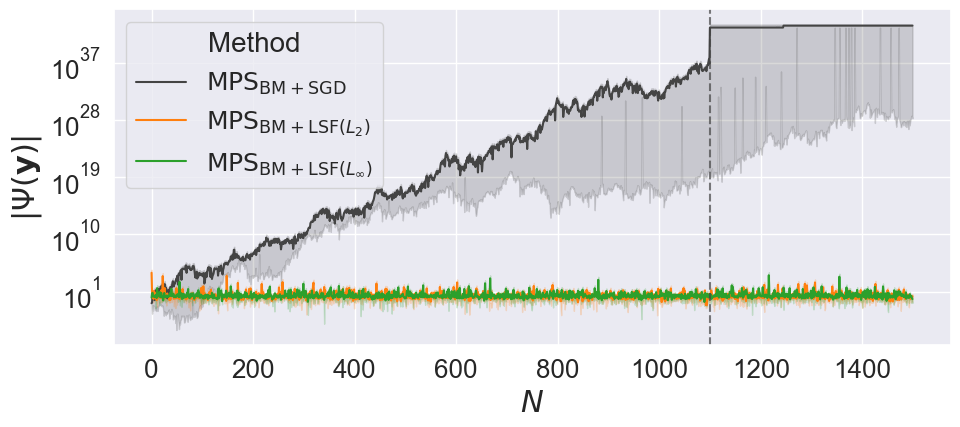

In [14]:
import torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from collections import OrderedDict

torch.manual_seed(42); np.random.seed(42)

EXPS = [
    # (r"$\mathrm{MPS}_\mathrm{abs+SGD}$",     lambda W: W.abs(), lambda py: py, False),
    # (r"$\mathrm{MPS}_\mathrm{sq+SGD}$",       lambda W: W.square(), lambda py: py, False),
    # (r"$\mathrm{MPS}_\mathrm{exp+SGD}$",  lambda W: W.exp(), lambda py: py, False),
    (r"$\mathrm{MPS}_\mathrm{BM+SGD}$",         lambda W: W, lambda py: py, False),  # special case
    (r"$\mathrm{MPS}_{\mathrm{BM+LSF} (L_2)}$",         lambda W: W, lambda py: py, 'l2'),  # special case
    (r"$\mathrm{MPS}_{\mathrm{BM+LSF} (L_\infty)}$",         lambda W: W, lambda py: py, 'linf'),  # special case

]

T, D = 1500, 2
rows, inf_at = [], {}

for seed in [0, 42, 84]:
    for name, fn, py_fn, stabilize in EXPS:
        alpha, beta, hit = fn(torch.randn(D)), fn(torch.randn(D)), False
        for t in range(T):
            if not hit:
                beta = torch.mv(fn(torch.randn(D, D)), beta)
                if stabilize:
                    denom = {
                        'l2': beta.norm(),
                        'linf': beta.max(),
                    }[stabilize]
                    beta = beta / beta.max()
                hit = not torch.isfinite(beta).all()
                if hit: inf_at[name] = t
            psi = float("inf") if hit else float(py_fn(torch.dot(alpha, beta)))
            rows.append({"Step": t, "Method": name, "psi": abs(psi)})

df = pd.DataFrame(rows)
finite = df[np.isfinite(df["psi"])]["psi"]
cap = (finite.max() if not finite.empty else 1.0) * 1e5
df["psi"] = df["psi"].replace([np.inf], cap)

# Build custom palette: softer black (dark gray) for "None"
base_colors = sns.color_palette("tab10", len(EXPS))
palette = {name: base_colors[i] for i, (name, _, _, _) in enumerate(EXPS)}
palette["$\mathrm{MPS}_\mathrm{BM+SGD}$"] = "#444444"   

# Increase font size for all elements
sns.set_theme(
    font_scale=1.7,
    rc={
        "axes.labelsize": 22,
        "axes.titlesize": 24,
        # "xtick.labelsize": 18,
        # "ytick.labelsize": 18,
        "legend.fontsize": 18,
        "legend.title_fontsize": 20,
    }
)
fig, ax = plt.subplots(figsize=(9, 4))
sns.lineplot(data=df, x="Step", y="psi", hue="Method", palette=palette, ax=ax)
plt.yscale("log")
plt.xlabel("$N$", fontsize=22)
plt.ylabel(r"$|\Psi(\mathbf{y})|$", fontsize=22)
# vertical lines for inf
for (name, _, _, _), color in zip(EXPS, [palette[n] for n, _, _, _ in EXPS]):
    if name in inf_at:
        plt.axvline(inf_at[name], color=color, ls="--", alpha=0.7, label=f"{name} inf@{inf_at[name]}")

# dedupe legend
h, l = ax.get_legend_handles_labels()
uniq = OrderedDict(zip(l, h))

plt.tight_layout(pad=0)  # Remove extra whitespace
plt.subplots_adjust(left=0.05, right=0.98, top=0.97, bottom=0.13)  # Fine-tune to remove whitespace
plt.show()


## Figure 5: Stability analysis (Part II)

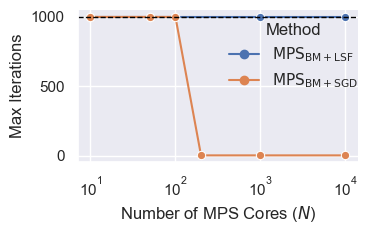

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot max iterations achieved by different methods and horizons
# plt.figure(figsize=(2,1.2))  # make figure shorter
sns.set_theme()

# Instability:
# >>> python scripts/profile_instability.py --horizons 10 50 100 200 1000 10000
#          name  horizon  iters
# 0  mps_bm_lsf       10   1000
# 1  mps_bm_lsf      100   1000
# 2  mps_bm_lsf      200   1000
# 3  mps_bm_lsf     1000   1000
# 4  mps_bm_lsf    10000   1000
# 5  mps_bm_sgd       10   1000
# 6  mps_bm_sgd      100   1000
# 7  mps_bm_sgd      200      1
# 8  mps_bm_sgd     1000      1
# 9  mps_bm_sgd    10000      1

# create df
df = pd.DataFrame(
    [
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 10, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 50, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 100, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 1000, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+LSF}}$", "horizon": 10000, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 10, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 50, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 100, "iters": 1000},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 200, "iters": 1},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 1000, "iters": 1},
        {"name": r"$\mathrm{MPS}_{\mathrm{BM+SGD}}$", "horizon": 10000, "iters": 1},
    ]
)

df["Method"] = df["name"]

# Rename columns for plotting
df = df.rename(columns={
    "iters": "Max Iterations",
    "horizon": "Number of MPS Cores ($N$)",
})
g = sns.relplot(
    data=df,
    x="Number of MPS Cores ($N$)",
    y="Max Iterations",
    hue="Method",
    kind="line",
    marker="o",       # one style only
    dashes=False,
    height=2.5,       # make relplot figure shorter
)
g.ax.set_xscale("log")

# Horizontal reference line
g.ax.axhline(1000, color="black", linestyle="--", linewidth=1)
g._legend.set_loc("upper right")
g._legend.set_bbox_to_anchor((0.95, 0.9))   # inset a little

plt.tight_layout()
plt.show()


## Figure 6: Latency Analysis

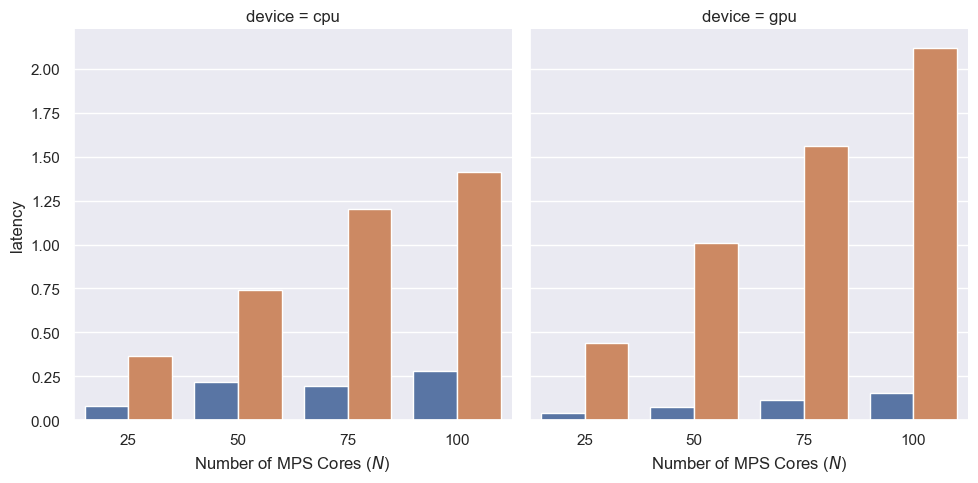

In [7]:
# Latency results:
# >> python scripts/profile_latency.py --horizons 25 50 75 100 --d_output 8 --models mps_sigma_lsf mps_bm_lsf mps_bm_dmrg --device cpu  --out results/latency_sweep_cpu.csv
# >> python scripts/profile_latency.py --horizons 25 50 75 100 --d_output 8 --models mps_sigma_lsf mps_bm_lsf mps_bm_dmrg --device cuda --out results/latency_sweep_gpu.csv

df_cpu = pd.read_csv("../results/latency_sweep_cpu.csv")
df_gpu = pd.read_csv("../results/latency_sweep_gpu.csv")
df_cpu['device'] = 'cpu'
df_gpu['device'] = 'gpu'
df = pd.concat([df_cpu, df_gpu])

# Rename methods
df['name'] = df['name'].replace({
    'mps_sigma_lsf': r'$\mathrm{MPS}_{\sigma+\mathrm{LSF}}$',
    'mps_bm_lsf': r'$\mathrm{MPS}_{BM+\mathrm{LSF}}$',
    'mps_bm_dmrg': r'$\mathrm{MPS}_{\mathrm{BM}+\mathrm{DMRG}}$'
})
# Filter only bm
df = df[df['name'].str.contains('BM')]
df['Number of MPS Cores ($N$)'] = df['H']

sns.set_theme()
g = sns.catplot(
    data=df,
    x="Number of MPS Cores ($N$)",
    y="latency",
    hue="name",
    col="device",
    kind="bar"
)
# hide legend
g._legend.remove()


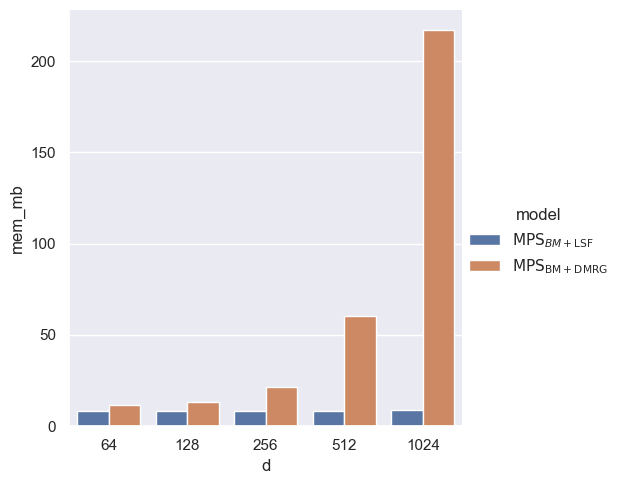

In [6]:
# Memory results:
# >> python scripts/profile_memory.py --d_outputs 64 128 256 512 1024 --models mps_sigma_lsf mps_bm_lsf mps_bm_dmrg

df_memory = pd.read_csv("../results/memory_sweep.csv")

# Rename methods
df_memory['model'] = df_memory['model'].replace({
    'mps_sigma_lsf': r'$\mathrm{MPS}_{\sigma+\mathrm{LSF}}$',
    'mps_bm_lsf': r'$\mathrm{MPS}_{BM+\mathrm{LSF}}$',
    'mps_bm_dmrg': r'$\mathrm{MPS}_{\mathrm{BM}+\mathrm{DMRG}}$'
})

# Filter only bm
df_memory = df_memory[df_memory['model'].str.contains('BM')]

sns.set_theme()
sns.catplot(
    data=df_memory,
    x="d",
    y="mem_mb",
    hue="model",
    kind="bar"
)

## Table 2 UCLA Experiments

In [36]:
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm

def load_wandb_runs(
    project: str,
    log_specs=None,
    config_attrs=None,
    entity=None,
):
    """
    Load runs from a wandb project, extracting logs and config attributes.
    
    Args:
        project (str): Project name, e.g. "username/project".
        log_specs (list[dict]): Each dict should have
            - 'name': str, name of the metric (e.g. "val/loss")
            - 'reduce': str, one of {"min", "max", "last", "mean"}
        config_attrs (list[str]): List of config attributes to extract.
        entity (str, optional): W&B entity/org if needed.
    
    Returns:
        pd.DataFrame: Table of runs with configs + extracted metrics.
    """
    api = wandb.Api()
    runs = api.runs(project if entity is None else f"{entity}/{project}")

    rows = []
    for run in tqdm(runs):
        row = {"run_id": run.id, "name": run.name, "state": run.state}

        # pull configs
        if config_attrs:
            for attr in config_attrs:
                row[attr] = run.config.get(attr, None)

        # pull logs - get full history first, then filter
        if log_specs:
            # Get full history instead of filtering by keys
            history = run.history()
            
            for spec in log_specs:
                key = spec["name"]
                reduce = spec.get("reduce", "last")

                if key not in history.columns:
                    row[f"{key}_{reduce}"] = None
                    continue

                series = history[key].dropna().to_numpy()
                if len(series) == 0:
                    row[f"{key}_{reduce}"] = None
                else:
                    if reduce == "last":
                        row[f"{key}_{reduce}"] = series[-1]
                    elif reduce == "min":
                        row[f"{key}_{reduce}"] = np.min(series)
                    elif reduce == "max":
                        row[f"{key}_{reduce}"] = np.max(series)
                    elif reduce == "mean":
                        row[f"{key}_{reduce}"] = np.mean(series)
                    else:
                        raise ValueError(f"Unknown reducer: {reduce}")

        rows.append(row)

    return pd.DataFrame(rows)



In [37]:
df_dmrg = load_wandb_runs('ptn-dmrg', log_specs=[{'name': 'eval/loss', 'reduce': 'min'}, {'name': 'horizon', 'reduce': 'min'}], config_attrs=['dataset'])

100%|██████████| 26/26 [00:08<00:00,  3.01it/s]


In [38]:
df_ptn = load_wandb_runs('ptn-ucla', log_specs=[{'name': 'val/loss', 'reduce': 'min'}], config_attrs=['dataset', 'model'])

100%|██████████| 88/88 [01:22<00:00,  1.07it/s]


In [39]:
# UCLA x DMRG
df_dmrg_proc = df_dmrg.copy()
df_dmrg_proc = df_dmrg_proc[df_dmrg_proc['state'] == 'finished']
df_dmrg_proc['nll'] = df_dmrg_proc['eval/loss_min'].astype(float) / df_dmrg_proc['horizon_min'].astype(float)
df_dmrg_proc['dataset'] = df_dmrg_proc['name'].map(lambda x: x.split('-')[0])
# Keep only relevant columns for summary
df_dmrg_proc = df_dmrg_proc[["run_id", "dataset", "eval/loss_min", "horizon_min", "nll"]]

# Group by dataset and keep the minimum nll and horizon_min
df_dmrg_proc = (
    df_dmrg_proc
    .groupby('dataset', as_index=False)
    .agg({'horizon_min': 'min', 'nll': 'min'})
)
df_dmrg_proc.sort_values('horizon_min')


,dataset,horizon_min,nll
16,nltcs,16,0.383886
14,msnbc,17,0.356078
11,kdd,64,0.033837
17,plants,69,0.201611
10,jester,100,0.550680
2,baudio,100,0.433557
4,bnetflix,100,0.606398
0,accidents,111,0.329720
19,retail,135,0.083437
18,pumsb_star,163,0.186920


In [40]:
# UCLA x PTN
import pandas as pd
df_ptn_proc = df_ptn.copy()
df_ptn_proc = df_ptn_proc[df_ptn_proc['state'] == 'finished']
df_ptn_proc['nll'] = df_ptn_proc['val/loss_min'].astype(float)
df_ptn_proc = df_ptn_proc[['dataset', 'model', 'nll']]
df_ptn_proc = df_ptn_proc.groupby(['dataset']).agg({'nll': 'min'}).reset_index()
df_ptn_proc

,dataset,nll
0,accidents,0.351874
1,baudio,NaN
2,bbc,0.257443
3,bnetflix,NaN
4,book,0.074922
5,cwebkb,0.209170
6,dna,0.444423
7,jester,0.538051
8,kosarek,0.180317
9,msnbc,NaN


In [59]:
df_ptn_sgd = pd.DataFrame(
    [
        {"dataset": "nltcs", "SGD": 0.38},
        {"dataset": "msnbc", "SGD": 0.36},
        {"dataset": "kdd", "SGD": 0.33},
        {"dataset": "plants", "SGD": 0.37},
    ]
)

In [66]:
# Merge
df_merged = pd.merge(
    df_dmrg_proc.rename(columns={'nll': 'DMRG', 'horizon_min': 'N'}),
    df_ptn_proc.rename(columns={'nll': 'LSF'}),
    on=['dataset'],
    how='left'
)
#  Filter
df_merged = df_merged[
    df_merged['DMRG'].notna() & df_merged['LSF'].notna() &
    (df_merged['DMRG'] != np.inf) & (df_merged['LSF'] != np.inf)
]

# Merge with SGD
df_merged = pd.merge(
    df_merged,
    df_ptn_sgd,
    on=['dataset'],
    how='left'
)
# reorder columns
df_merged = df_merged[['dataset', 'N', 'SGD', 'DMRG', 'LSF']]

# Remove kosarek dataset
df_merged = df_merged[df_merged['dataset'] != 'kosarek']

# Round to 2 decimal places
df_merged = df_merged.round(2)
df_merged = df_merged.sort_values('N')

# Function to bold the minimum value in each row
def bold_min_latex(row):
    dmrg_val = row['DMRG']
    lsf_val = row['LSF']
    sgd_val = row['SGD']
    
    if dmrg_val < lsf_val:
        row['DMRG'] = f"\\textbf{{{dmrg_val}}}"
        row['LSF'] = f"{lsf_val}"
        row['SGD'] = f"{sgd_val}"
    elif lsf_val < dmrg_val:
        row['DMRG'] = f"{dmrg_val}"
        row['LSF'] = f"\\textbf{{{lsf_val}}}"
        row['SGD'] = f"{sgd_val}"
    else:
        row['DMRG'] = f"{dmrg_val}"
        row['LSF'] = f"{lsf_val}"
        row['SGD'] = f"{sgd_val}"
    return row

# latex table
df_merged['SGD'] = df_merged['SGD'].fillna('\\xmark')
df_merged = df_merged.apply(bold_min_latex, axis=1)
print(df_merged.to_latex(index=False, escape=False, column_format='lcccc'))


\begin{tabular}{lcccc}
\toprule
dataset & N & SGD & DMRG & LSF \\
\midrule
nltcs & 16 & 0.38 & 0.38 & 0.38 \\
plants & 69 & 0.37 & \textbf{0.2} & 0.28 \\
jester & 100 & \xmark & 0.55 & \textbf{0.54} \\
accidents & 111 & \xmark & \textbf{0.33} & 0.35 \\
retail & 135 & \xmark & 0.08 & 0.08 \\
dna & 180 & \xmark & 0.46 & \textbf{0.44} \\
book & 500 & \xmark & 0.07 & 0.07 \\
tmovie & 500 & \xmark & 0.12 & 0.12 \\
cwebkb & 839 & \xmark & 0.21 & 0.21 \\
\bottomrule
\end{tabular}

